# MLP-CW4 Baseline execution notebook

This notebook is not for data exploration. But to log execution of experiments.
This job runs baseline 5 times and save results to files/


## Imports

In [1]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

/home/as12production/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Environment Settings

In [2]:
#Keras setting
K.set_image_dim_ordering('tf')  #Image dimension ordering

#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (224,224)  # Image size. Process on the by data generator. Should match CNN model input. 
IMAGE_INPUT_SIZE = (224,224,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 20

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '../TRAIN' 
VAL_DIR = '../VALID'
TEST_DIR =  '../TEST'

#Index of the class label represents numerical representation
CLASS_LABELS = ["Benign", "Malignant"]
NUM_CLASSES = 2

## Loading Dataset

In [3]:
def buildImageDataset(path, imageResize=None,shuffle=False,seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

In [4]:
run_this = 0

if run_this == 1:
    X_train, y_train, _ = buildImageDataset(TRAIN_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
    X_valid, y_valid, _ = buildImageDataset(VAL_DIR,imageResize=IMAGE_RESIZE,seed=SEED)

    with open("X_train.pickle", "wb") as output_file:
            pickle.dump(X_train, output_file)

    with open("y_train.pickle", "wb") as output_file:
            pickle.dump(y_train, output_file)

    with open("X_valid.pickle", "wb") as output_file:
            pickle.dump(X_valid, output_file)

    with open("y_valid.pickle", "wb") as output_file:
            pickle.dump(y_valid, output_file)
else:
    X_train = pickle.load( open( "X_train.pickle", "rb" ) )
    y_train = pickle.load( open( "y_train.pickle", "rb" ) )
    X_valid = pickle.load( open( "X_valid.pickle", "rb" ) )
    y_valid = pickle.load( open( "y_valid.pickle", "rb" ) )
    

## Pre-Processing


In [5]:
X_train /= 255.0
X_valid /= 255.0
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)

# Building Neural Net Model

In [6]:
# Building Models
def InceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with 1 sigmoid for binary classification
    sgd = SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                        weights='imagenet',  #Pre-train on ImageNet 
                                                        input_tensor=Input(shape=IMAGE_INPUT_SIZE),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=NUM_CLASSES)
    final = Model(input=model.input,output=Dense(NUM_CLASSES, activation='softmax')(model.output))
    final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

# Required Function Definitions

In [7]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot

In [8]:
def generateTrainingPlots(history, accuracy_grap_file, loss_graph_file):
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim((0,1))
    plt.xlabel('Epoch Number')
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.ylim((0,1))
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data    
    accuracy_plot.savefig(accuracy_grap_file, bbox_inches='tight')
    loss_plot.savefig(loss_graph_file, bbox_inches='tight')


In [9]:
def evaluateClassifier(history, classifier, weights, X ,y , cm_file, out_file, classlabels):
    classifier.load_weights(weights)
    y_pred = classifier.predict(X)
    cm = confusion_matrix(np.argmax(y,axis=1), np.argmax(np.rint(y_pred),axis=1))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=classlabels)
    plot.savefig(cm_file, bbox_inches='tight')
    scores = classifier.evaluate(X_valid,y_valid)
    with open(out_file, 'w') as the_file:
        the_file.write("Max Val Acc: " + str(np.max(np.array(history['val_acc']))))
        the_file.write("\nMin Val Acc: " + str(np.min(np.array(history['val_acc']))))
        the_file.write("\nMax Train Acc: "  + str(np.max(np.array(history['acc']))))
        the_file.write("\nMin Train Acc: "  + str(np.min(np.array(history['acc']))))
        the_file.write("\nMax Val Err: "  + str(np.max(np.array(history['val_loss']))))
        the_file.write("\nMin Val Err: " + str(np.min(np.array(history['val_loss']))))
        the_file.write("\nMax Train Err: " + str(np.max(np.array(history['loss']))))
        the_file.write("\nMin Train Err: " +  str(np.min(np.array(history['loss']))))
        the_file.write("\nResult: " + str(scores))
        the_file.write("\nResult: " +  str(model.metrics_names))
        

# Training & Visualizing & Evaluating

Running Experiment Iteration 1


/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 5252 samples, validate on 1735 samples
Epoch 1/20
5252/5252 [==============================] - 138s 26ms/step - loss: 0.2944 - acc: 0.8713 - val_loss: 0.8485 - val_acc: 0.7908

Epoch 00001: val_acc improved from -inf to 0.79078, saving model to run#1_baseline-inception3-weights.hdf5
Epoch 2/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.1365 - acc: 0.9480 - val_loss: 0.7932 - val_acc: 0.6899

Epoch 00002: val_acc did not improve
Epoch 3/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0981 - acc: 0.9667 - val_loss: 0.5915 - val_acc: 0.8501

Epoch 00003: val_acc improved from 0.79078 to 0.85014, saving model to run#1_baseline-inception3-weights.hdf5
Epoch 4/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0442 - acc: 0.9844 - val_loss: 2.6745 - val_acc: 0.5879

Epoch 00004: val_acc did not improve
Epoch 5/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0421 - acc: 0.9869 - val_los

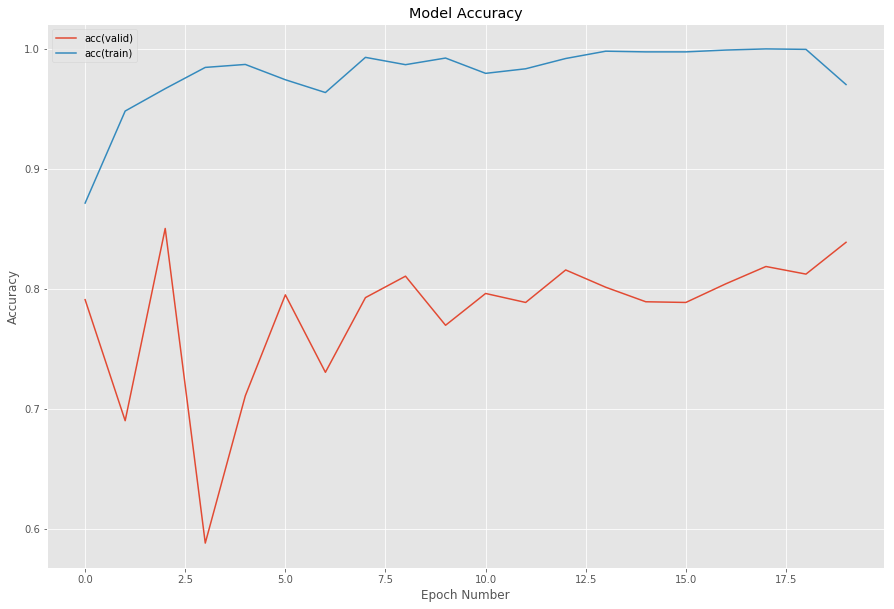

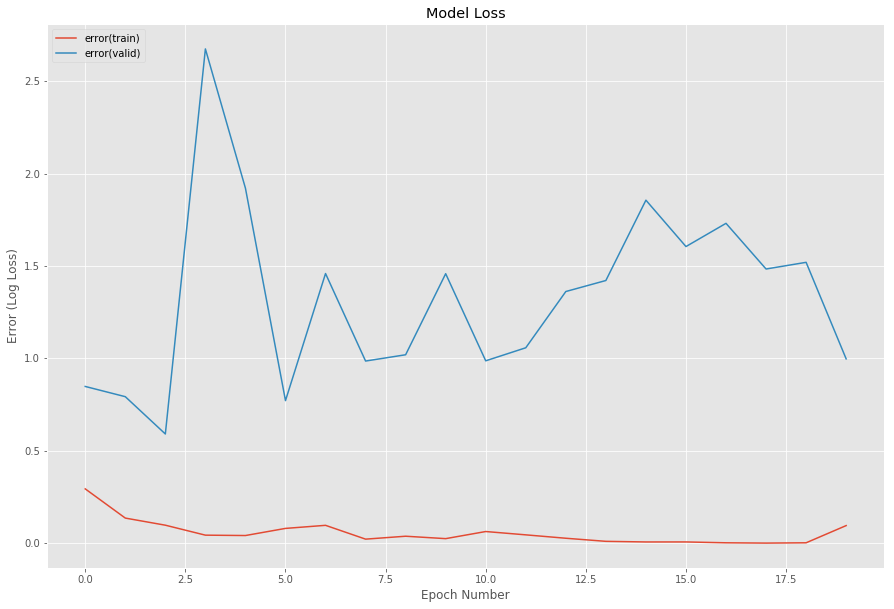

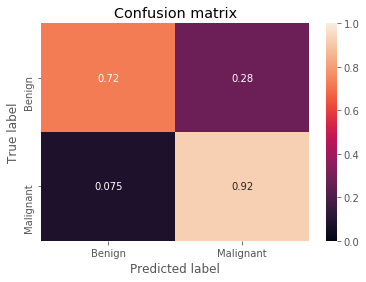

1735/1735 [==============================] - 15s 9ms/step
Running Experiment Iteration 2


/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 5252 samples, validate on 1735 samples
Epoch 1/20
5252/5252 [==============================] - 139s 26ms/step - loss: 0.2708 - acc: 0.8882 - val_loss: 2.3697 - val_acc: 0.4571

Epoch 00001: val_acc improved from -inf to 0.45706, saving model to run#2_baseline-inception3-weights.hdf5
Epoch 2/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.1791 - acc: 0.9257 - val_loss: 1.0325 - val_acc: 0.5591

Epoch 00002: val_acc improved from 0.45706 to 0.55908, saving model to run#2_baseline-inception3-weights.hdf5
Epoch 3/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0756 - acc: 0.9752 - val_loss: 0.8584 - val_acc: 0.7585

Epoch 00003: val_acc improved from 0.55908 to 0.75850, saving model to run#2_baseline-inception3-weights.hdf5
Epoch 4/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.1195 - acc: 0.9562 - val_loss: 0.6739 - val_acc: 0.8069

Epoch 00004: val_acc improved from 0.75850 to 0.80692, saving model to ru

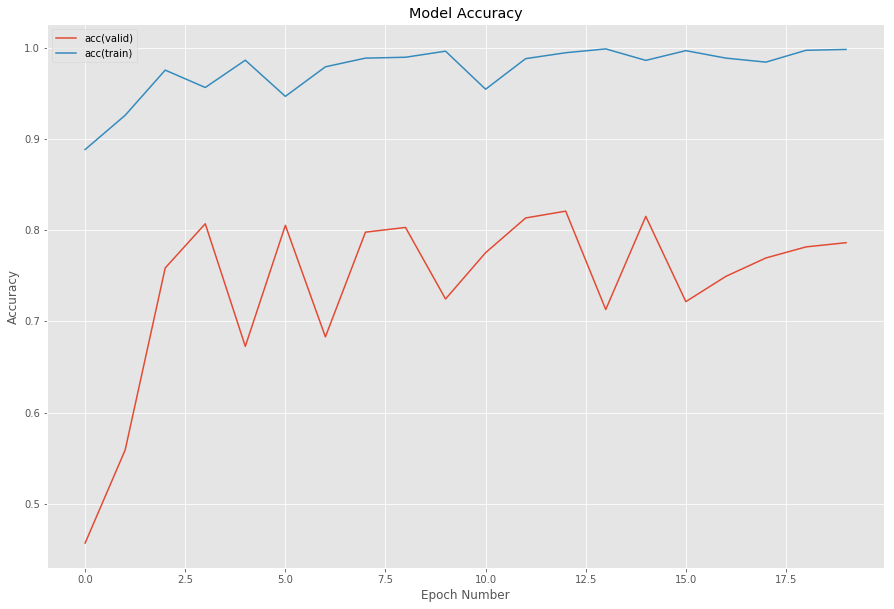

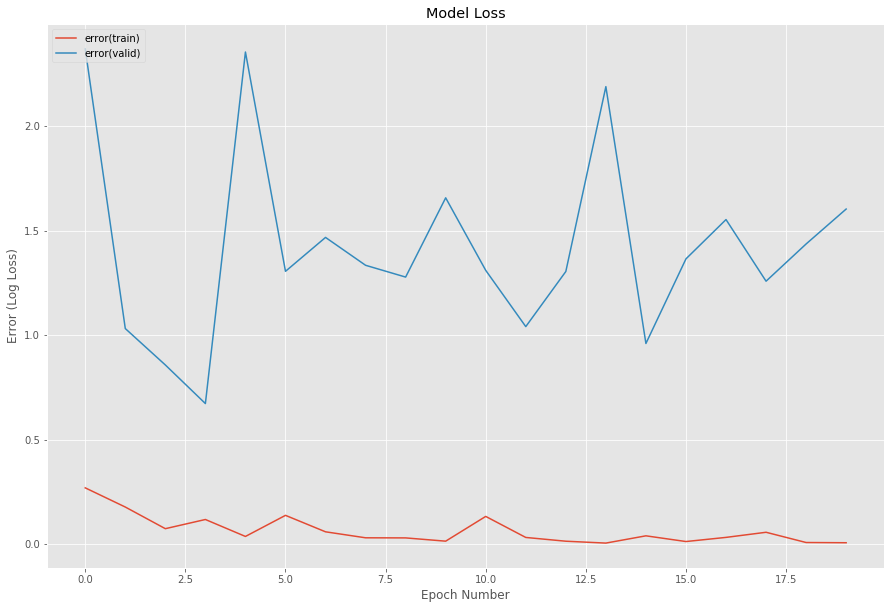

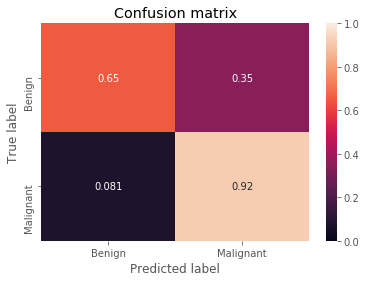

1735/1735 [==============================] - 16s 9ms/step
Running Experiment Iteration 3
Train on 5252 samples, validate on 1735 samples
Epoch 1/20
5252/5252 [==============================] - 143s 27ms/step - loss: 0.2692 - acc: 0.8842 - val_loss: 2.0367 - val_acc: 0.5937

Epoch 00001: val_acc improved from -inf to 0.59366, saving model to run#3_baseline-inception3-weights.hdf5
Epoch 2/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.1732 - acc: 0.9335 - val_loss: 1.1007 - val_acc: 0.7499

Epoch 00002: val_acc improved from 0.59366 to 0.74986, saving model to run#3_baseline-inception3-weights.hdf5
Epoch 3/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.1151 - acc: 0.9560 - val_loss: 0.5872 - val_acc: 0.7954

Epoch 00003: val_acc improved from 0.74986 to 0.79539, saving model to run#3_baseline-inception3-weights.hdf5
Epoch 4/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0943 - acc: 0.9655 - val_loss: 1.0503 - v

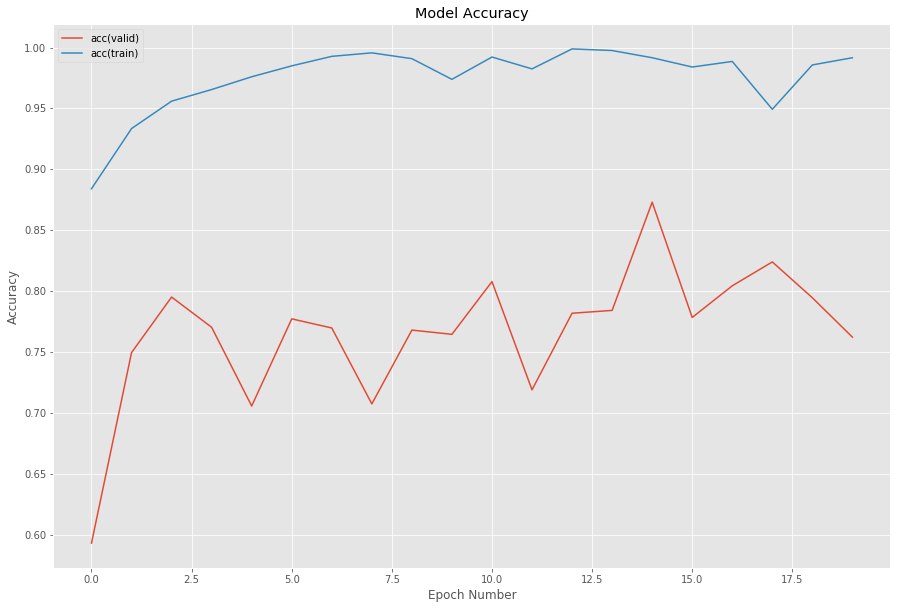

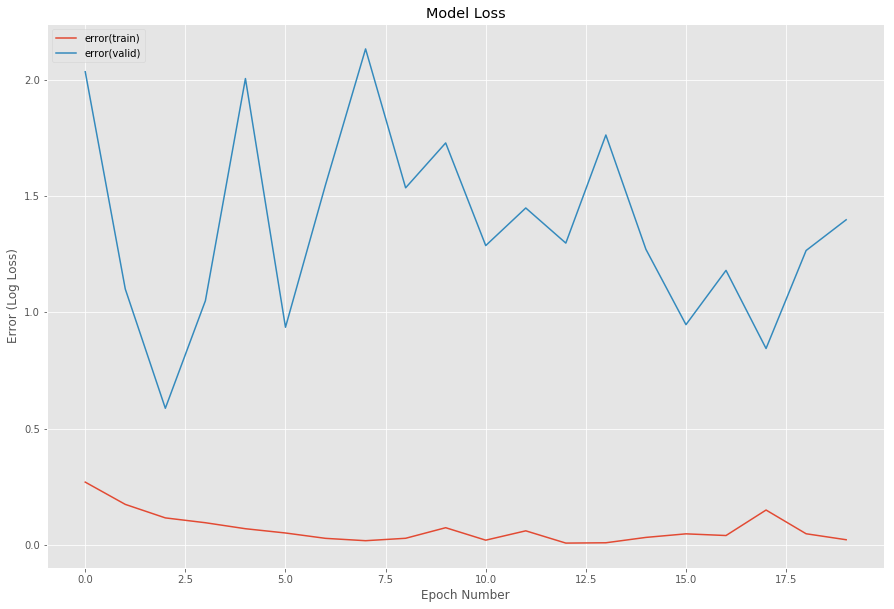

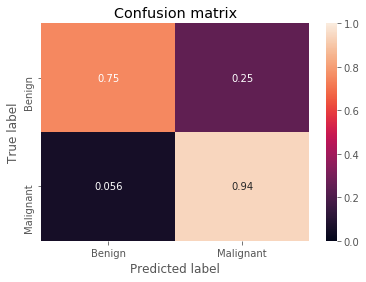

1735/1735 [==============================] - 19s 11ms/step
Running Experiment Iteration 4
Train on 5252 samples, validate on 1735 samples
Epoch 1/20
5252/5252 [==============================] - 147s 28ms/step - loss: 0.2932 - acc: 0.8797 - val_loss: 0.7572 - val_acc: 0.8513

Epoch 00001: val_acc improved from -inf to 0.85130, saving model to run#4_baseline-inception3-weights.hdf5
Epoch 2/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.1549 - acc: 0.9410 - val_loss: 2.0224 - val_acc: 0.6790

Epoch 00002: val_acc did not improve
Epoch 3/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.1010 - acc: 0.9629 - val_loss: 1.4767 - val_acc: 0.7683

Epoch 00003: val_acc did not improve
Epoch 4/20
5252/5252 [==============================] - 130s 25ms/step - loss: 0.0393 - acc: 0.9871 - val_loss: 1.9850 - val_acc: 0.6334

Epoch 00004: val_acc did not improve
Epoch 5/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.0804 - acc:

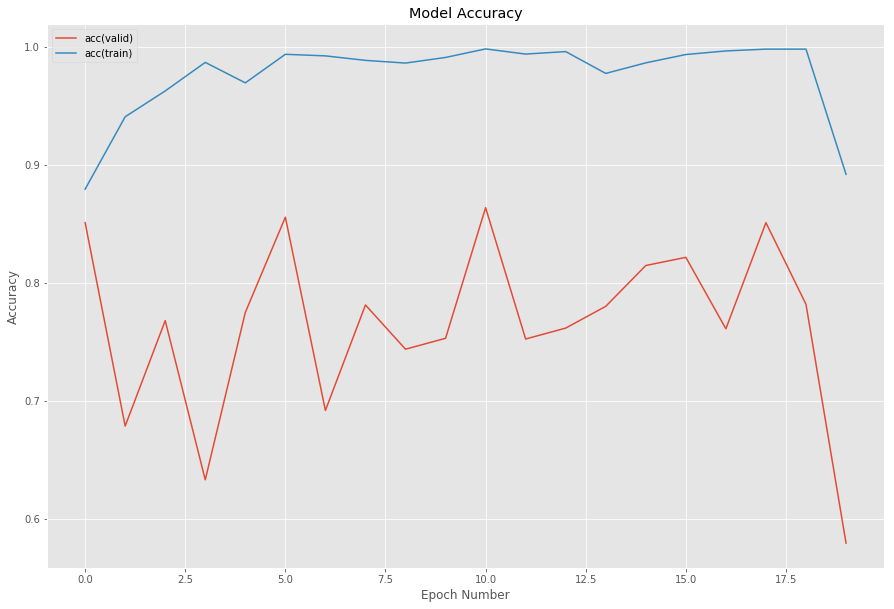

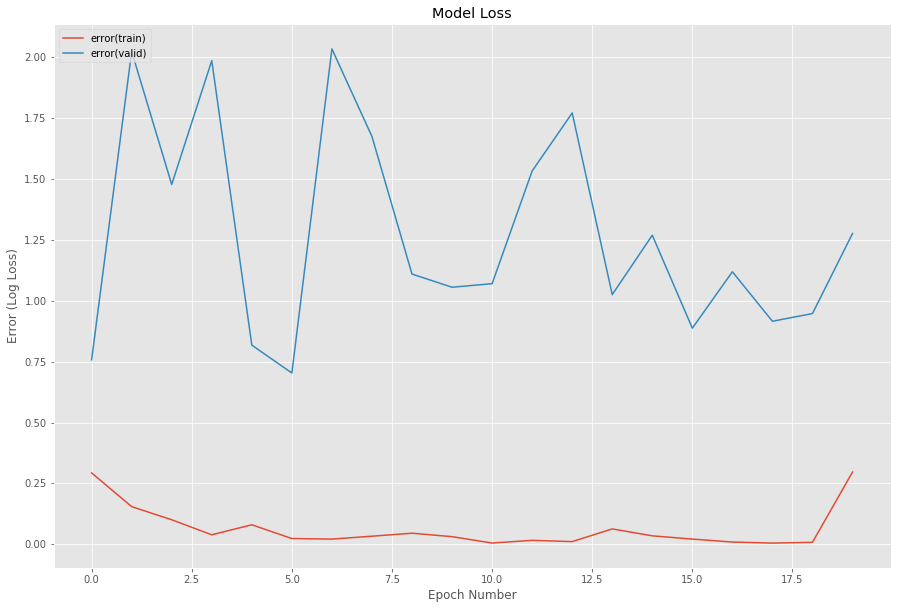

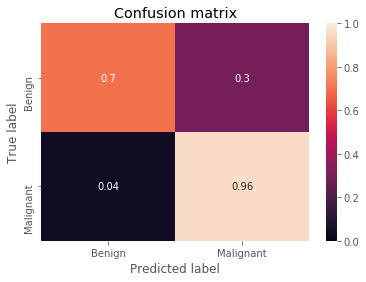

1735/1735 [==============================] - 21s 12ms/step
Running Experiment Iteration 5
Train on 5252 samples, validate on 1735 samples
Epoch 1/20
5252/5252 [==============================] - 153s 29ms/step - loss: 0.2570 - acc: 0.8941 - val_loss: 1.3078 - val_acc: 0.7308

Epoch 00001: val_acc improved from -inf to 0.73084, saving model to run#5_baseline-inception3-weights.hdf5
Epoch 2/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.1180 - acc: 0.9551 - val_loss: 0.7035 - val_acc: 0.7723

Epoch 00002: val_acc improved from 0.73084 to 0.77233, saving model to run#5_baseline-inception3-weights.hdf5
Epoch 3/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.0718 - acc: 0.9743 - val_loss: 1.2281 - val_acc: 0.7458

Epoch 00003: val_acc did not improve
Epoch 4/20
5252/5252 [==============================] - 131s 25ms/step - loss: 0.0322 - acc: 0.9878 - val_loss: 1.5909 - val_acc: 0.7988

Epoch 00004: val_acc improved from 0.77233 to 0.79885, s

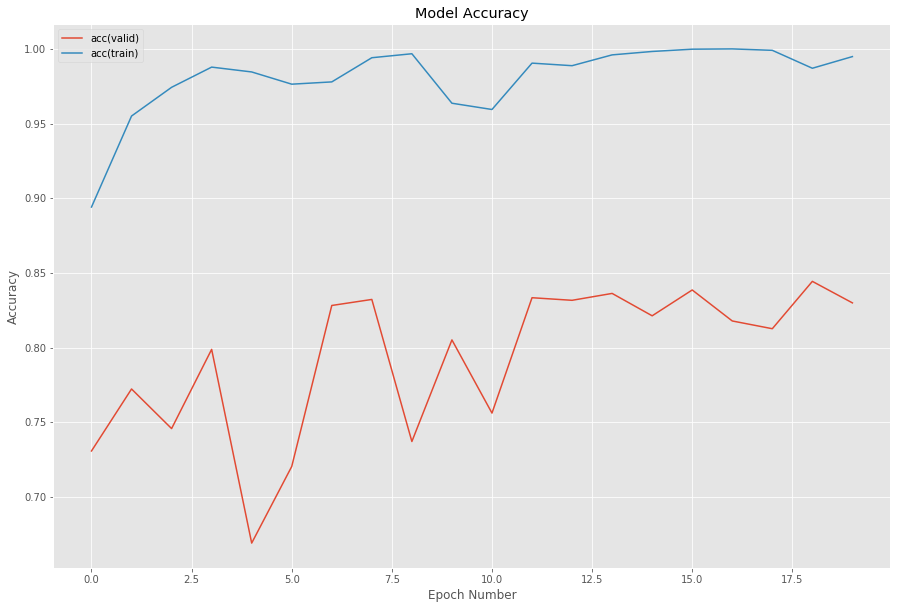

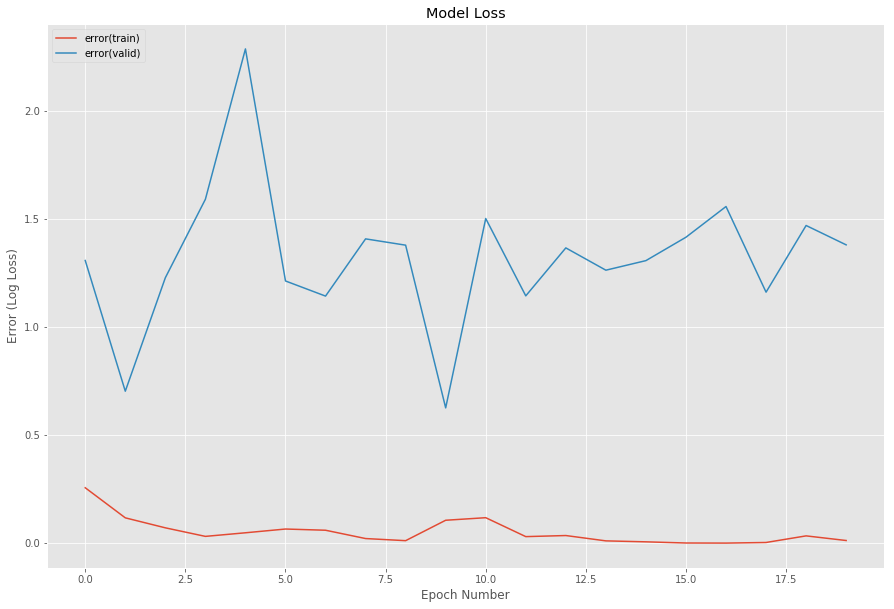

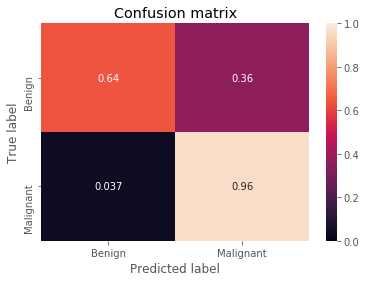

1735/1735 [==============================] - 23s 13ms/step


In [10]:
for i in range(1,6):
    print("Running Experiment Iteration",i)
    model = InceptionNet()
    #Process filenames
    prefix = "run#{}_".format(i)
    MODEL_CHECKPOINT_FILE=prefix + "baseline-inception3-weights.hdf5"  
    #Training charts and graphics
    MODEL_TRAIN_RESULTS_FILE=prefix + "baseline-inception3_train.pickle"
    MODEL_ACCURACY_GRAPH_FILE=prefix + "baseline-inception3_accuracy.pdf"
    MODEL_LOSS_GRAPH_FILE=prefix + "baseline-inception3_loss.pdf"
    MODEL_EVALUATION_CM_FILE=prefix + "baseline-inception3_CM.pdf"
    MODEL_EVALUATION_TEXT_FILE=prefix + "baseline-inception3_eval.txt"
    
    checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    #Training
    history = model.fit(x=X_train,y=y_train,
                        validation_data=(X_valid,y_valid),
                        batch_size=BATCH_SIZE,
                        epochs = EPOCH,
                        callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)    
    
    #Generate training graphs
    generateTrainingPlots(history.history, MODEL_ACCURACY_GRAPH_FILE, MODEL_LOSS_GRAPH_FILE)
    
    #evaluate classifier
    evaluateClassifier(history.history, InceptionNet(), MODEL_CHECKPOINT_FILE, 
                       X_valid ,y_valid , MODEL_EVALUATION_CM_FILE, MODEL_EVALUATION_TEXT_FILE, CLASS_LABELS)
    del model

In [11]:
print("Completed")

Completed
